In [1]:
from spectral_cube import SpectralCube
from astropy import units as u, coordinates

In [2]:
cd /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7


In [26]:
ls -lhrtd *.image

drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 13:17 G351.77_B6_spw7_12M_spw7_F_h_perchan_bigpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 13:29 G351.77_B6_spw7_12M_spw7_F_h_common_bigpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 14:22 G351.77_B6_spw7_12M_spw7_F_h_common_smallpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 14:27 G351.77_B6_spw7_12M_spw7_F_h_perchan_smallpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 16:33 G351.77_B6_spw7_12M_spw7_F_h_perchan_bigpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 16:39 G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 17:08 G351.77_B6_spw7_12M_spw7_F_h_common_smallpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 17:08 G351.77_B6_spw7_12M_spw7_F_h_common_bigpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adam

In [4]:
import warnings

In [5]:
crd = coordinates.SkyCoord('17:26:40.80 -36:08:53.2', frame='fk5', unit=(u.hour, u.deg))

In [ ]:
beams = {}
censpec = {}
mxspec = {}
params = {}
img = {}
spec2 = {}
sumwt = {}


In [31]:
spw = 7

for imsize, cell, sznm in ((768, '0.22arcsec', 'bigpix'), ([1080,1024], '0.13arcsec', 'smallpix')):
    for perchanweightdensity in (True, False):
        pcwd = 'T' if perchanweightdensity else 'F'
        for deconvolver in ('hogbom', 'multiscale'):
            dc = 'h' if deconvolver == 'hogbom' else 'm'
            for restoringbeam in ('', 'common'):
                rb = 'common' if restoringbeam == 'common' else 'perchan'
                for cyclefactor in (1.0, 2.0):
                    for startmodel in (f"/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G351.77_B6_spw{spw}_12M_spw{spw}.contcube.model", ""):
                        if startmodel and sznm == 'smallpix':
                            # can't use this startmodel b/c wrong size
                            continue
                        sm = "SM" if startmodel else "noSM"
                        for briggs in ('briggs', 'briggsbwtaper'):
                            bwt = 'bwt' if briggs == 'briggsbwtaper' else 'rob'

                            for smallscalebias in (-1.0, 0.0, 1.0):
                                if deconvolver == 'multiscale':
                                    dc = 'm'+str(smallscalebias)
                                else:
                                    dc = 'h'
                                imname = f"/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw{spw}_12M_spw{spw}_{pcwd}_{dc}_{rb}_{sznm}_cf{int(cyclefactor)}_{bwt}_{sm}"

                                hd = f"spw{spw}_{pcwd}_{dc}_{rb}_{sznm}_cf{int(cyclefactor)}_{sm}"

                                params[hd] = {'imsize': imsize,
                                              'cell': cell,
                                              'perchanweightdensity': perchanweightdensity,
                                              'deconvolver': deconvolver,
                                              'restoringbeam': restoringbeam,
                                              'cyclefactor': cyclefactor,
                                              'startmodel': sm,
                                              'smallscalebias': smallscalebias}

                                if os.path.exists(imname+".sumwt") and hd not in sumwt:
                                    with warnings.catch_warnings():
                                        warnings.simplefilter('ignore')
                                        sw = SpectralCube.read(imname+".sumwt", format='casa_image')
                                        sumwt[hd] = sw[:,0,0]

                                if os.path.exists(imname+".image") and hd not in img:
                                    with warnings.catch_warnings():
                                        warnings.simplefilter('ignore')
                                        cube = SpectralCube.read(imname+".image").with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=230.530*u.GHz)
                                        cube = cube.with_mask(cube>-9999*cube.unit) # HACK - error
                                        if hasattr(cube, 'beams'):
                                            beams[hd] = cube.beams
                                        else:
                                            beams[hd] = cube.beam
                                        censpec[hd] = cube[:,cube.shape[1]//2,cube.shape[2]//2]
                                        xpx,ypx = cube.wcs.celestial.wcs_world2pix(crd.ra.deg, crd.dec.deg, 0)
                                        spec2[hd] = cube[:, int(ypx), int(xpx)]
                                        img[hd] = cube[935,:,:]
                                        # takes too long mxspec[hd] = cube.max(axis=(1,2))
                                        print(imname, hd)

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_F_h_perchan_bigpix_cf1_rob_SM spw7_F_h_perchan_bigpix_cf1_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_F_h_perchan_bigpix_cf2_rob_SM spw7_F_h_perchan_bigpix_cf2_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_F_h_common_bigpix_cf1_rob_SM spw7_F_h_common_bigpix_cf1_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_F_h_common_bigpix_cf2_rob_SM spw7_F_h_common_bigpix_cf2_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_F_m-1.0_perchan_bigpix_cf1_rob_SM spw7_F_m-1.0_perchan_bigpix_cf1_SM
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_F_m0.0_perchan_bigpix_cf1_rob_SM spw7_F_m0.0_perchan_bigpix_cf1_SM
/orange/adamginsburg/ALM

In [32]:
len(params)

96

In [33]:
{key: val for key,val in params.items() if val['startmodel'] == 'SM'}

{'spw7_T_h_perchan_bigpix_cf1_SM': {'imsize': 768,
  'cell': '0.22arcsec',
  'perchanweightdensity': True,
  'deconvolver': 'hogbom',
  'restoringbeam': '',
  'cyclefactor': 1.0,
  'startmodel': 'SM',
  'smallscalebias': 1.0},
 'spw7_T_h_perchan_bigpix_cf2_SM': {'imsize': 768,
  'cell': '0.22arcsec',
  'perchanweightdensity': True,
  'deconvolver': 'hogbom',
  'restoringbeam': '',
  'cyclefactor': 2.0,
  'startmodel': 'SM',
  'smallscalebias': 1.0},
 'spw7_T_h_common_bigpix_cf1_SM': {'imsize': 768,
  'cell': '0.22arcsec',
  'perchanweightdensity': True,
  'deconvolver': 'hogbom',
  'restoringbeam': 'common',
  'cyclefactor': 1.0,
  'startmodel': 'SM',
  'smallscalebias': 1.0},
 'spw7_T_h_common_bigpix_cf2_SM': {'imsize': 768,
  'cell': '0.22arcsec',
  'perchanweightdensity': True,
  'deconvolver': 'hogbom',
  'restoringbeam': 'common',
  'cyclefactor': 2.0,
  'startmodel': 'SM',
  'smallscalebias': 1.0},
 'spw7_T_m-1.0_perchan_bigpix_cf1_SM': {'imsize': 768,
  'cell': '0.22arcsec',
  '

In [36]:
import pylab as pl

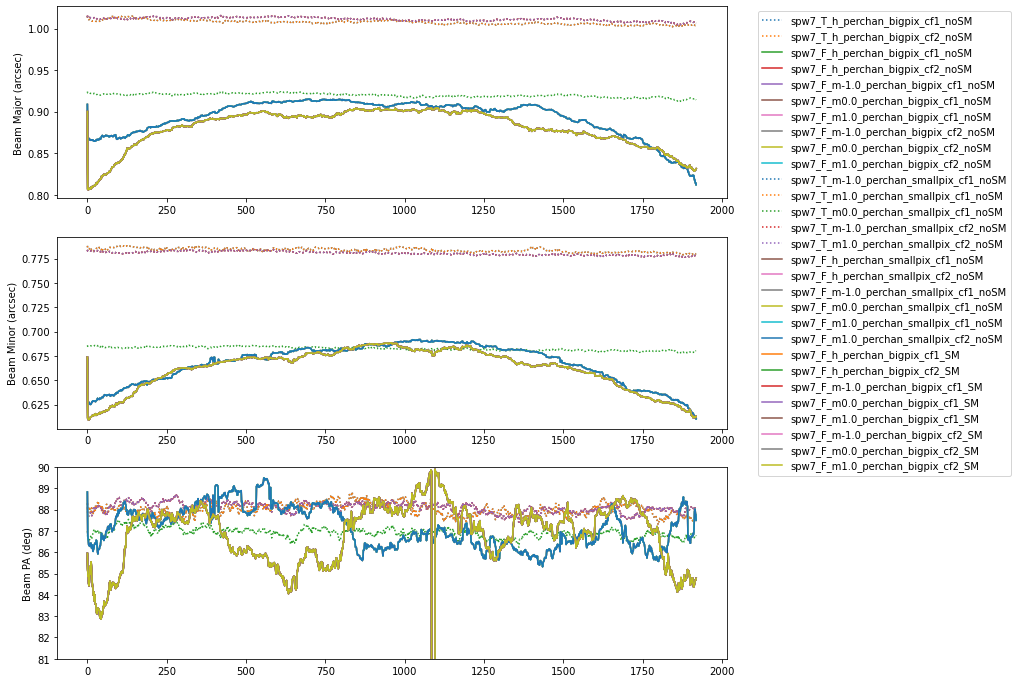

In [37]:
pl.figure(figsize=(12,12))
ax1 = pl.subplot(3,1,1)
ax2 = pl.subplot(3,1,2)
ax3 = pl.subplot(3,1,3)
for hd in beams:
    if np.isscalar(beams[hd].sr.value):
        pass
        #ax1.plot([0,1920], [beams[hd].major.value]*2, label=hd, linestyle='--')
        #ax2.plot([0,1920], [beams[hd].minor.value]*2, label=hd, linestyle=':')
        #ax3.plot([0,1920], [beams[hd].pa.to(u.deg).value]*2, label=hd, linestyle='--')
    else:
        ax1.plot(beams[hd].major, label=hd, linestyle=':' if '_T_' in hd else '-')
        ax2.plot(beams[hd].minor, label=hd, linestyle=':' if '_T_' in hd else '-')
        ax3.plot(beams[hd].pa.to(u.deg).value, label=hd, linestyle=':' if '_T_' in hd else '-')
ax1.set_ylabel("Beam Major (arcsec)")
ax2.set_ylabel("Beam Minor (arcsec)")
ax3.set_ylabel("Beam PA (deg)")
ax3.set_ylim([81,90])
pl.sca(ax1)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

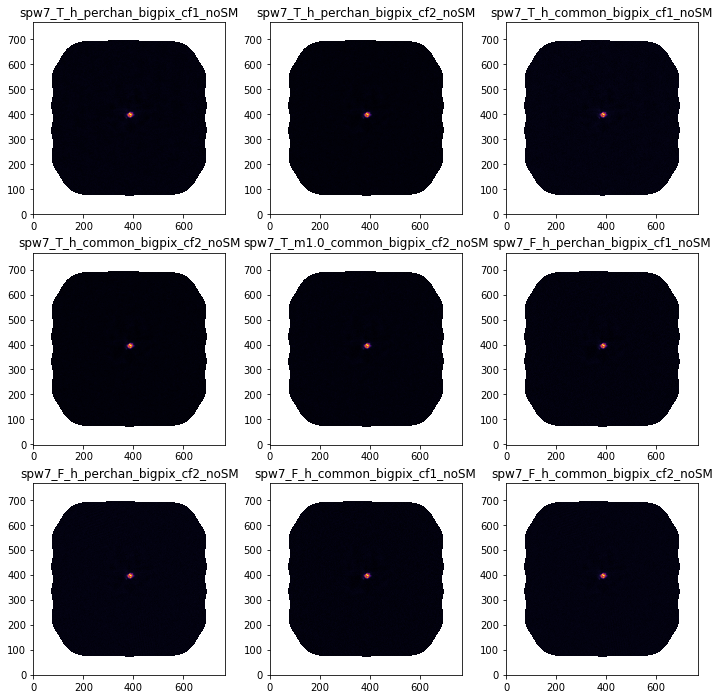

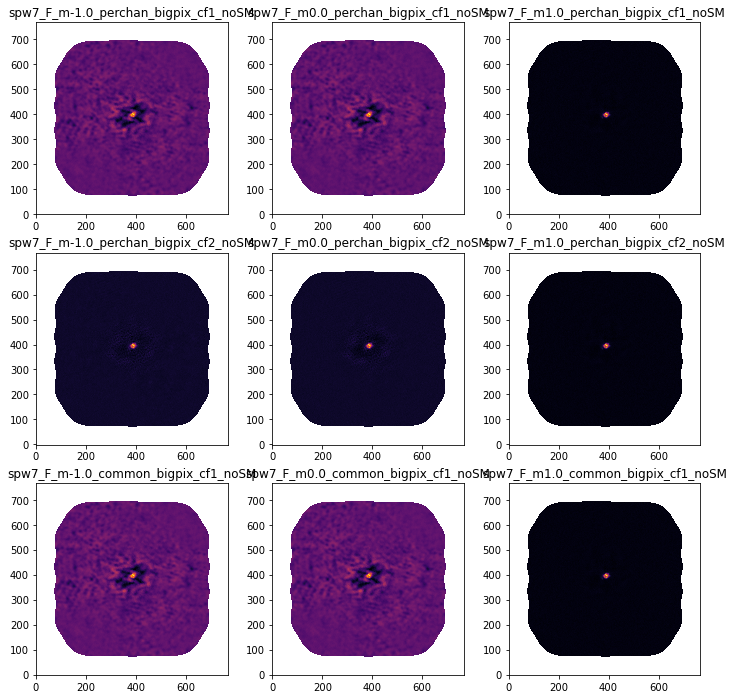

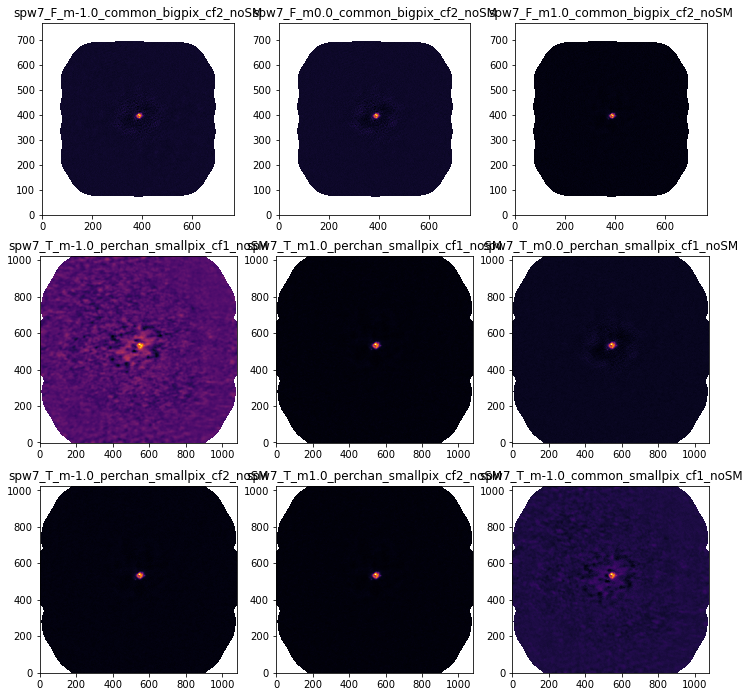

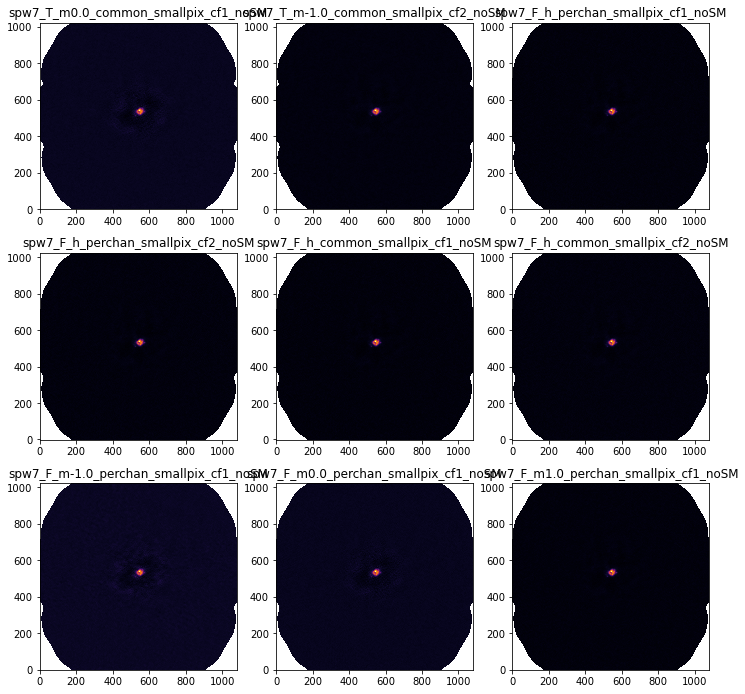

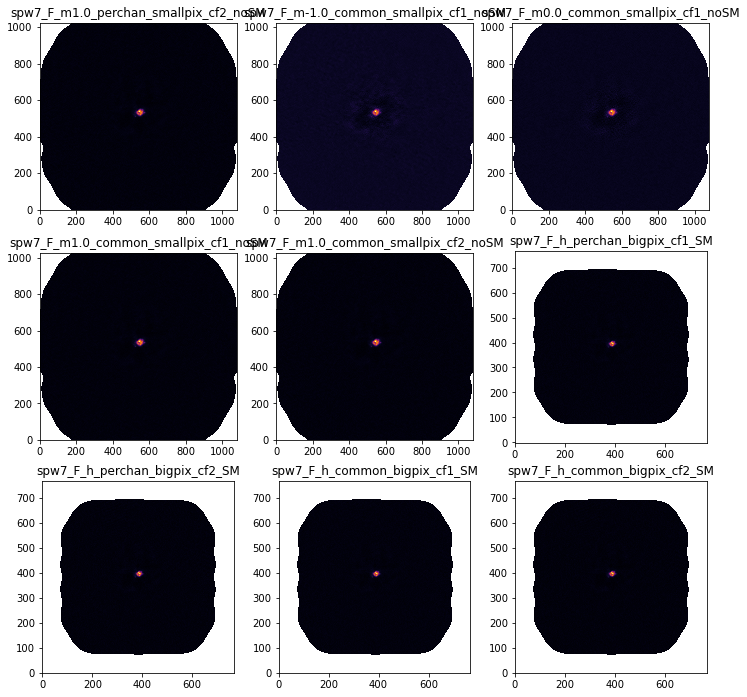

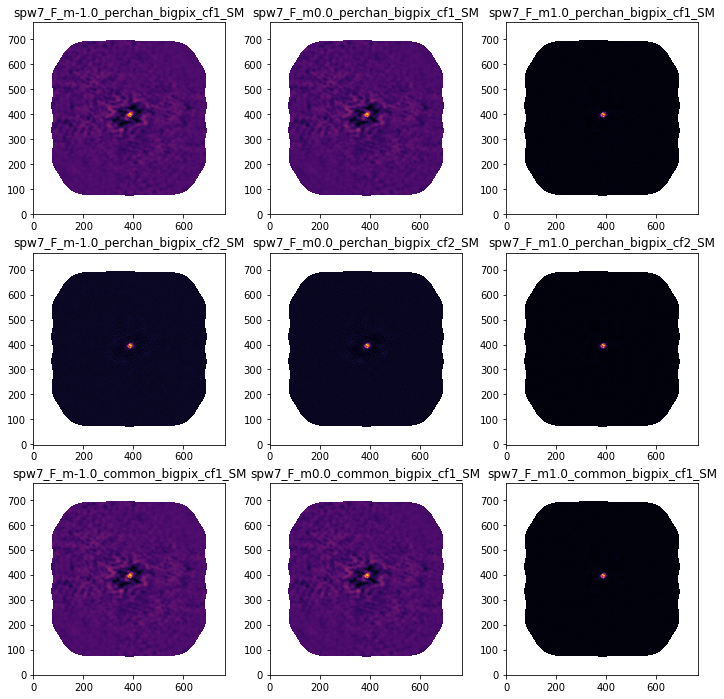

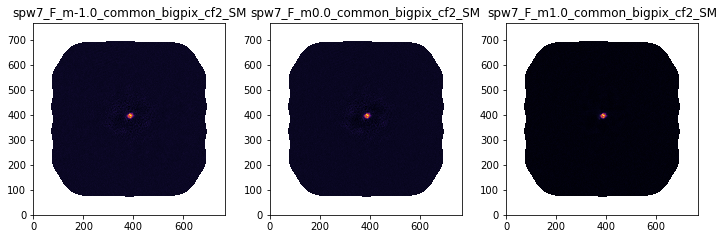

In [39]:
for ii,hd in enumerate(img):
    if ii % 9 == 0:
        pl.figure(figsize=(12,12))
    pl.subplot(3,3,ii%9+1).imshow(img[hd].value, origin='lower', interpolation='none', cmap='inferno')
    pl.title(hd)

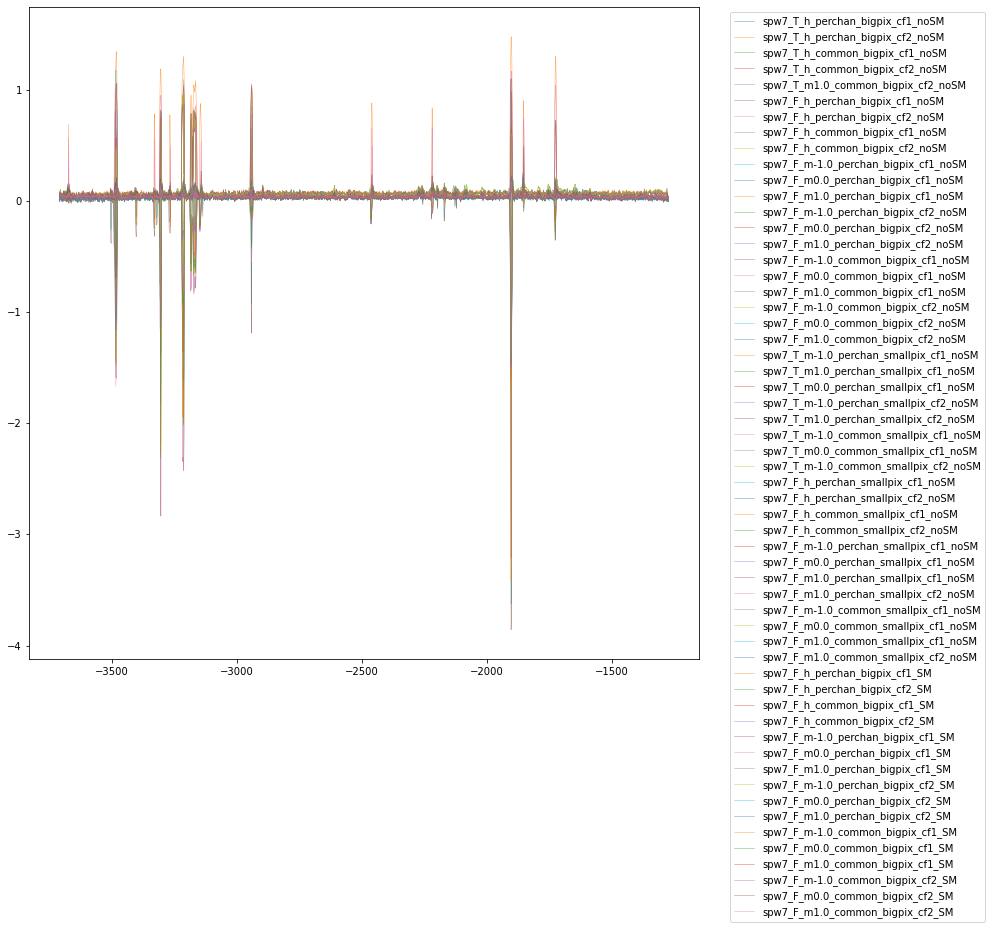

In [40]:
pl.figure(figsize=(12,12))
for hd in censpec:
    pl.plot(censpec[hd].spectral_axis, censpec[hd].value, label=hd, linewidth=0.5, alpha=0.7)
#pl.xlim(-100,50)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

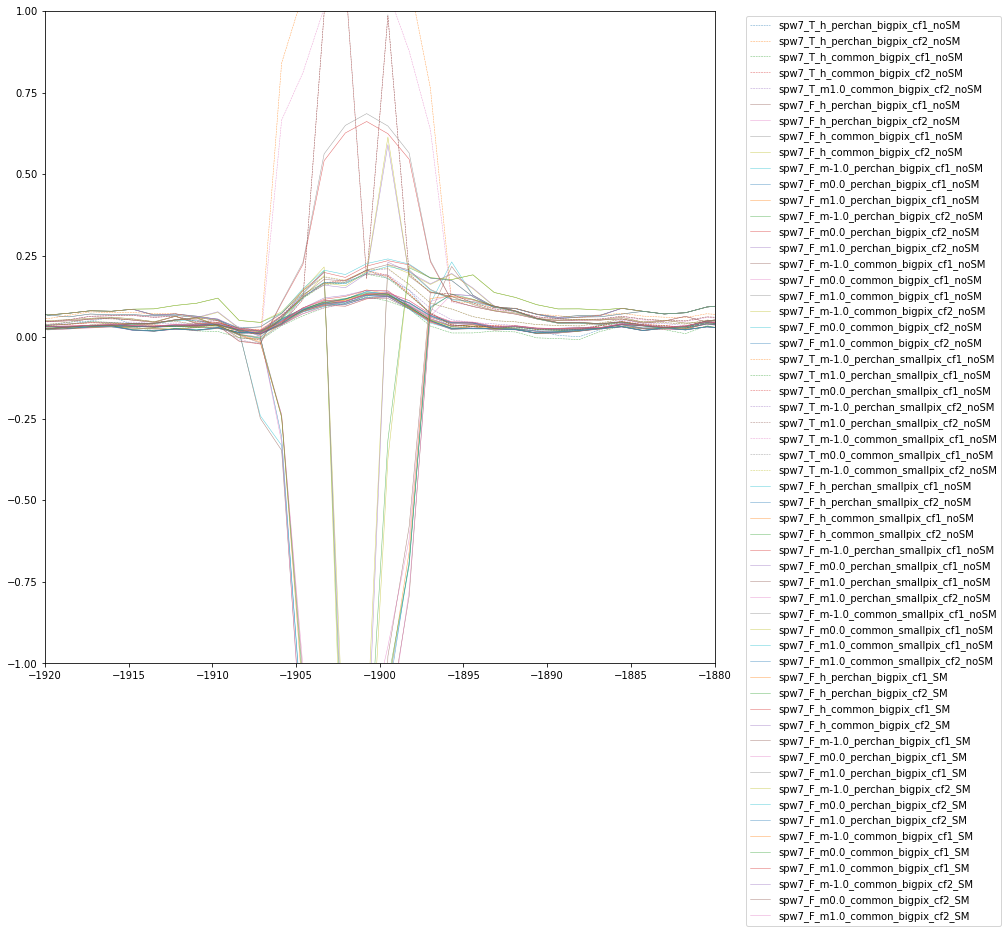

In [51]:
pl.figure(figsize=(12,12))
for hd in censpec:
    pl.plot(censpec[hd].spectral_axis, censpec[hd].value, label=hd, linewidth=0.5, alpha=0.7,
            linestyle='--' if '_T_' in hd else '-')
pl.xlim(-1920,-1880)
pl.ylim(-1,1)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

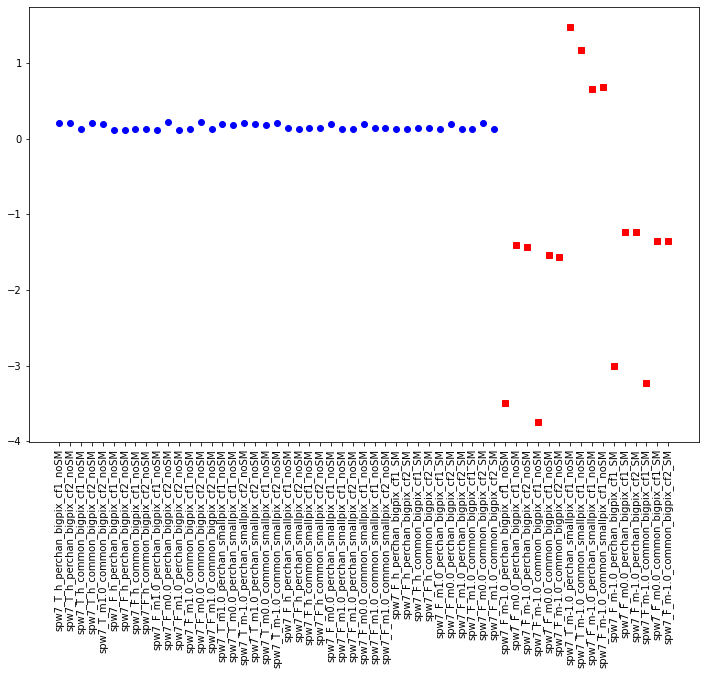

In [52]:
pl.figure(figsize=(12,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([censpec[hd][cube.closest_spectral_channel(-1901*u.km/u.s)].value for hd in hdl])
ok = (yy > 0.00) & (yy < 0.25)
pl.plot(xx[ok], yy[ok], 'bo')
pl.plot(xx[~ok], yy[~ok], 'rs')
_=pl.xticks(rotation=90)

In [53]:
xx[~ok]

array(['spw7_F_m-1.0_perchan_bigpix_cf1_noSM',
       'spw7_F_m0.0_perchan_bigpix_cf1_noSM',
       'spw7_F_m-1.0_perchan_bigpix_cf2_noSM',
       'spw7_F_m-1.0_common_bigpix_cf1_noSM',
       'spw7_F_m0.0_common_bigpix_cf1_noSM',
       'spw7_F_m-1.0_common_bigpix_cf2_noSM',
       'spw7_T_m-1.0_perchan_smallpix_cf1_noSM',
       'spw7_T_m-1.0_common_smallpix_cf1_noSM',
       'spw7_F_m-1.0_perchan_smallpix_cf1_noSM',
       'spw7_F_m-1.0_common_smallpix_cf1_noSM',
       'spw7_F_m-1.0_perchan_bigpix_cf1_SM',
       'spw7_F_m0.0_perchan_bigpix_cf1_SM',
       'spw7_F_m-1.0_perchan_bigpix_cf2_SM',
       'spw7_F_m-1.0_common_bigpix_cf1_SM',
       'spw7_F_m0.0_common_bigpix_cf1_SM',
       'spw7_F_m-1.0_common_bigpix_cf2_SM'], dtype='<U38')

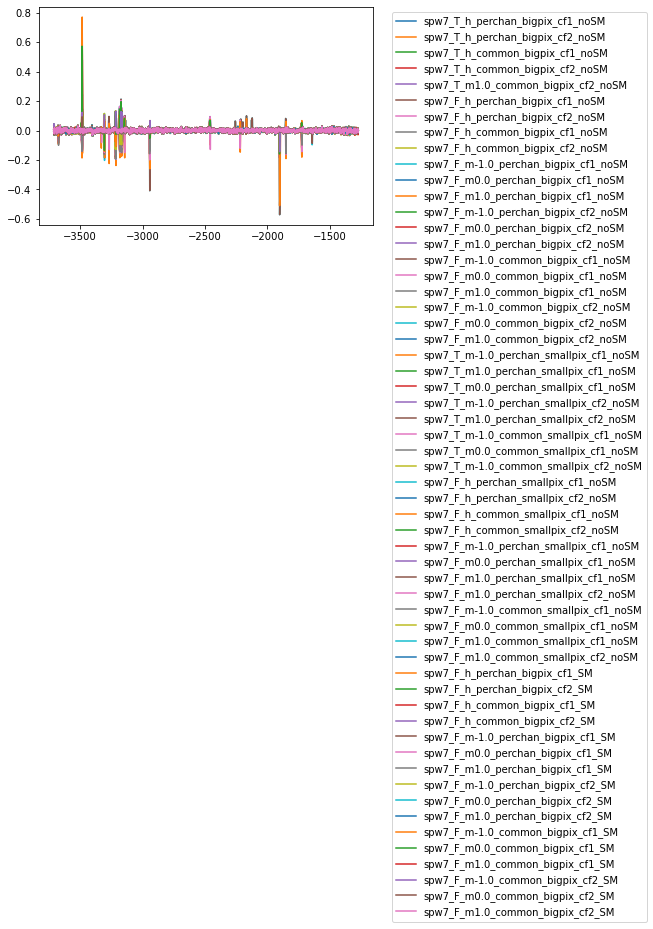

In [45]:
for hd in spec2:
    pl.plot(spec2[hd].spectral_axis, spec2[hd].value, label=hd)
#pl.xlim(-100,50)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

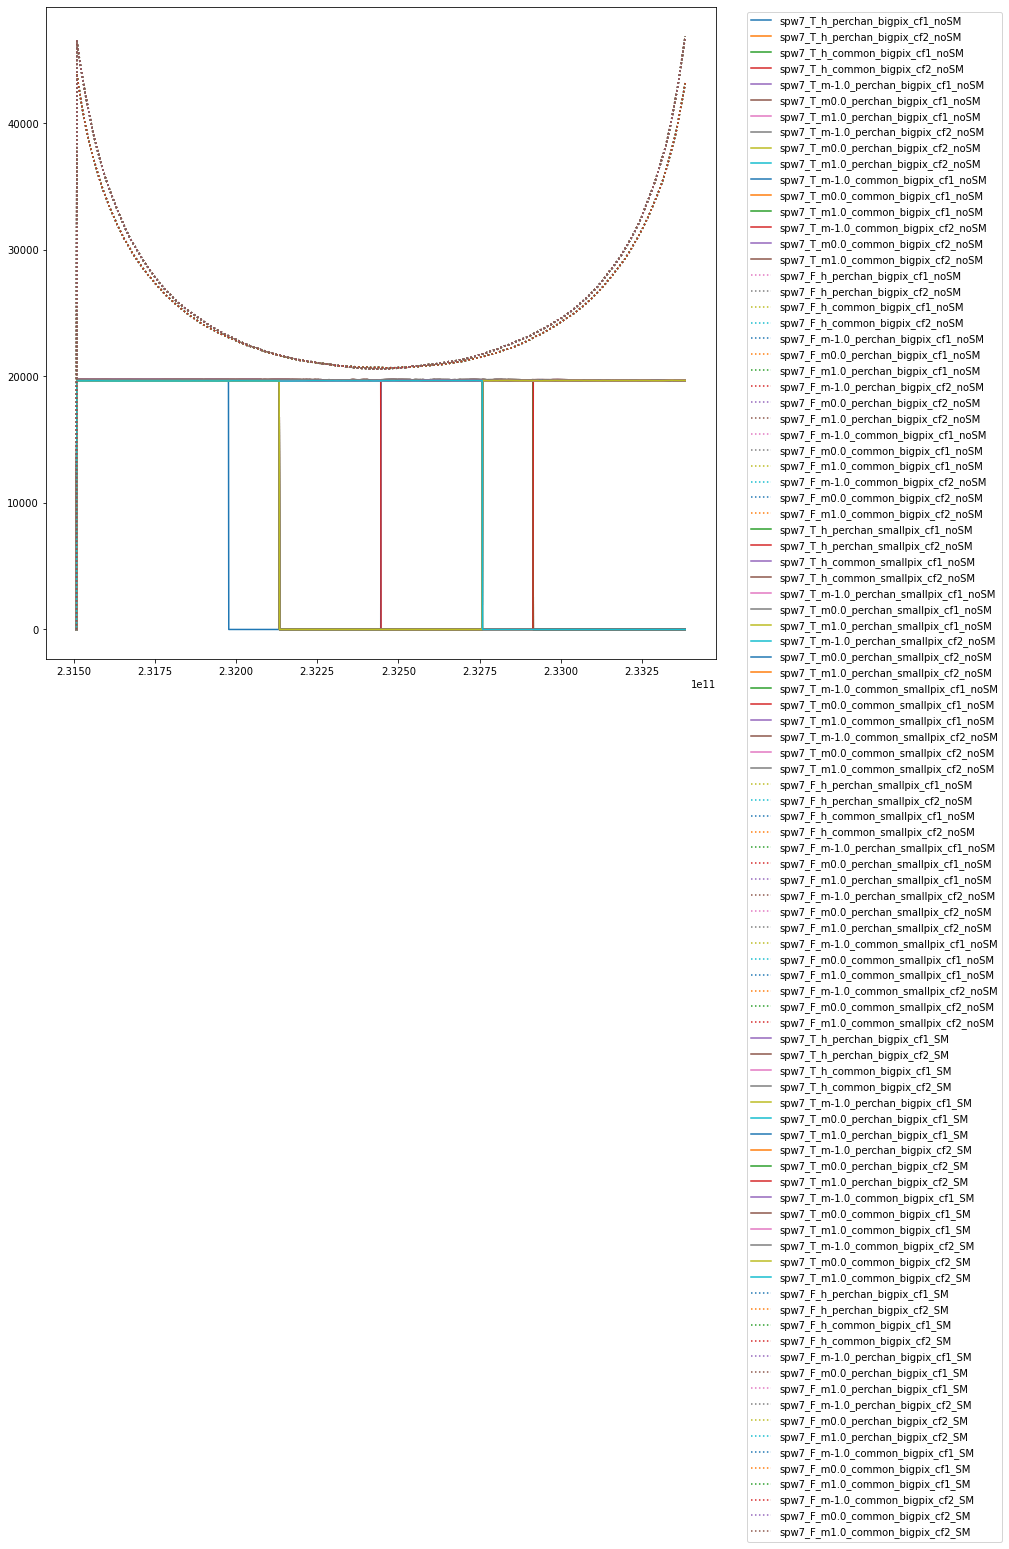

In [46]:
pl.figure(figsize=(12,12))
for hd in sumwt:
    linestyle = ':' if '_F_' in hd else '-'
    pl.plot(sumwt[hd].spectral_axis, sumwt[hd].value, label=hd, linestyle=linestyle)
#pl.xlim(-100,100)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

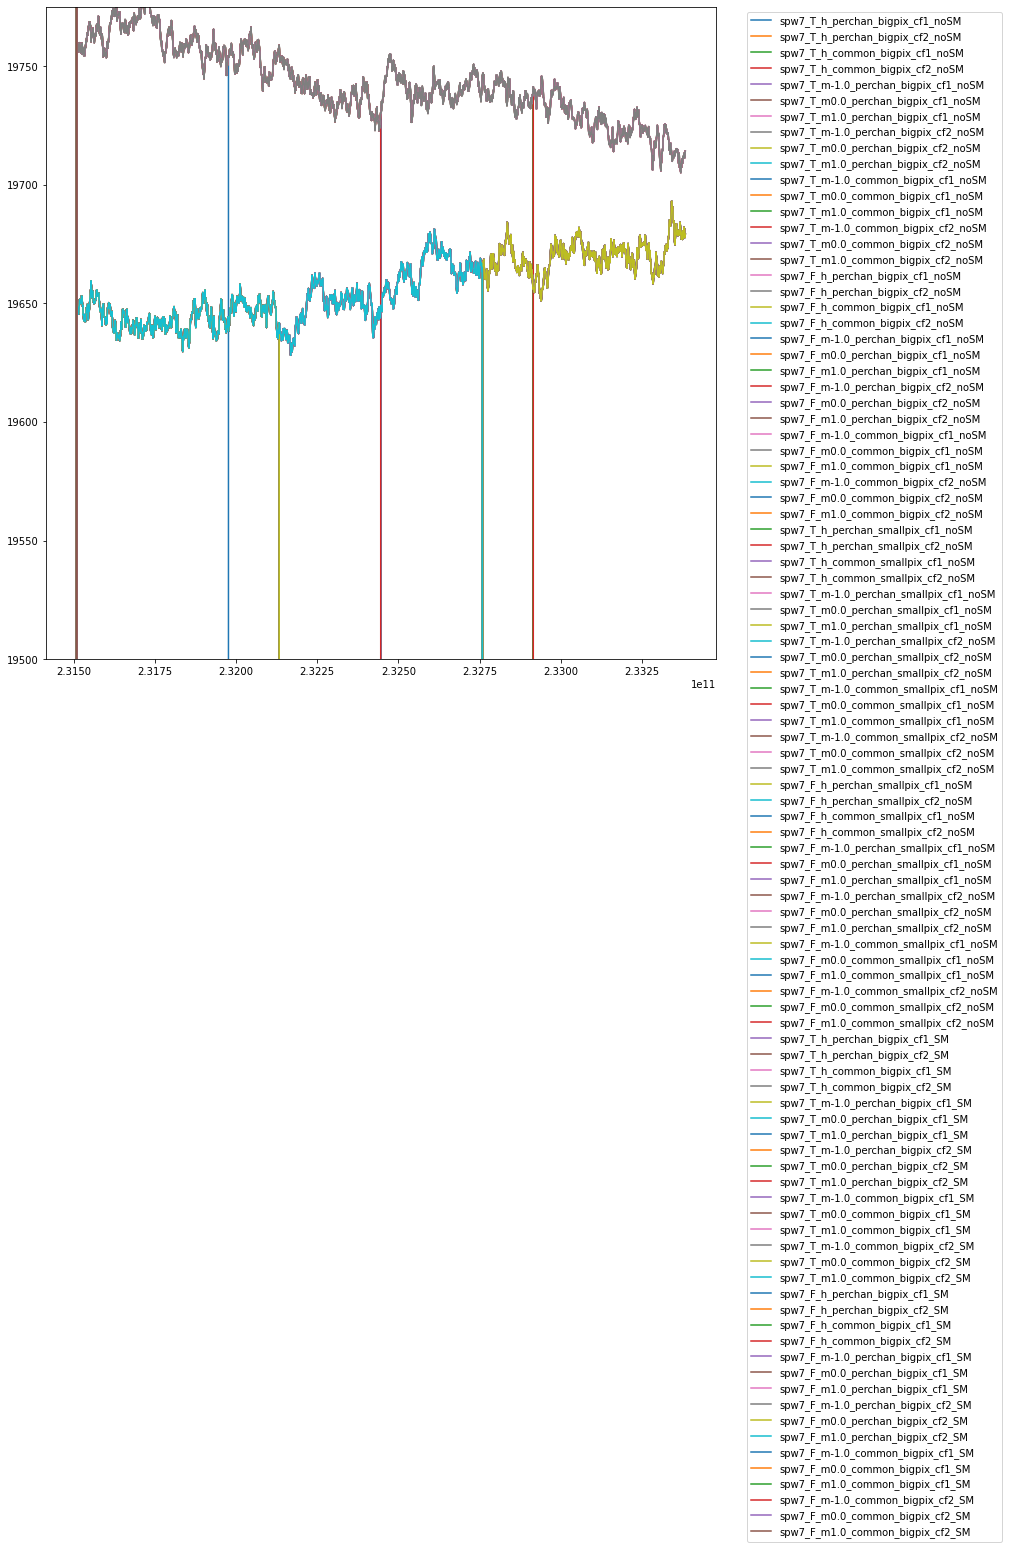

In [47]:
pl.figure(figsize=(12,12))
for hd in sumwt:
    pl.plot(sumwt[hd].spectral_axis, sumwt[hd].value, label=hd)
pl.ylim(19500,19775)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")